In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import lda
import os
import pdb
import nltk
import string
import json
import random
import pickle
import pandas as pd

from IPython.display import clear_output
from os import makedirs
from os.path import join, exists

In [2]:
INPUT_DIR = join('tmp', 'parsed')
OUTPUT_DIR = join('tmp')
makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
from nltk.stem.porter import PorterStemmer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [4]:
print("Building vocabulary...")

docs = {}
doc_tokens = {}
for fname in os.listdir(INPUT_DIR):
    if fname != '.DS_Store':
        with open(join(INPUT_DIR, fname), 'r') as f:
            doc = json.load(f)
            docs[doc['id']] = doc
            text = doc['body']
            table = str.maketrans({key: None for key in string.punctuation})
            text = text.lower().translate(table)
            doc_tokens[doc['id']] = text

token_keys = [x[0] for x in doc_tokens.items()]
token_values = [x[1] for x in doc_tokens.items()]
print(len(doc_tokens.items()))

Building vocabulary...
9086


# Build the graph from scratch

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Processing TF-IDF")

vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
X = vectorizer.fit_transform(token_values)

print(X.shape)

Processing TF-IDF
(9086, 141273)


In [6]:
g = ig.Graph()
for i, key in enumerate(token_keys):
    g.add_vertices(key)
    
print(g.vcount())

9086


In [10]:
g.delete_edges(g.es)
edges = []
for i, key in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for i_2, key_2 in enumerate(token_keys):
        edges.append((key, key_2))
            
g.add_edges(edges)  
edges = [] 
print(g.ecount())

82555396


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

count = 0
weights = []
for i, key in enumerate(token_keys):
    similarities = cosine_similarity(X[i], X)[0]
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for i_2, key_2 in enumerate(token_keys):            
        g.es[count]["weight"] = similarities[i_2]
        count += 1

print(g.ecount())

82555396


Remove duplicated and self-loop edges

In [13]:
g.simplify(multiple=True, loops=True, combine_edges="max")
print(g.ecount())

41273155


In [14]:
g.es[1]['weight']

0.027366185195034684

In [15]:
g.write_gml('tmp/igraph.gml')

In [65]:
g = ig.Graph.Read_GML('tmp/igraph.gml')

FileNotFoundError: [Errno 2] No such file or directory: 'tmp/igraph_01.gml'

In [16]:
g.es[1].tuple

(0, 2)

In [17]:
g.vs[0]

igraph.Vertex(<igraph.Graph object at 0x10e1f0d68>, 0, {'name': '2016-05-01-1'})

In [73]:
sub_g = g.es.select(weight_ge=0).subgraph()

In [75]:
print("Nodes {}".format(sub_g.vcount()))
print("Edges {}".format(sub_g.ecount()))
# print("Diameter {}".format(sub_g.diameter()))
# print("LCC {}".format(sub_g.clusters().giant().vcount()))
# print("APL {}".format(sub_g.average_path_length()))
print("AD {}".format(sum(sub_g.degree())/len(sub_g.degree())))

Nodes 9086
Edges 41273155
AD 9085.0


In [26]:
sub_g.es()[0].tuple

(0, 1734)

In [23]:
print(sub_g.vs[1])
print(sub_g.vs[3])

igraph.Vertex(<igraph.Graph object at 0x10e1f0c78>, 0, {'name': '2016-05-01-122'})
igraph.Vertex(<igraph.Graph object at 0x10e1f0c78>, 3, {'name': '2016-05-01-81'})


In [39]:
sub_g.write_gml('tmp/subgraph_01.gml')

# Community Detection

In [5]:
g = ig.Graph.Read_GML('tmp/subgraph_01.gml')

In [6]:
sg = g.es.select(weight_ge=0.2).subgraph()

In [7]:
# community = sg.community_infomap(edge_weights='weight')
community = sg.community_multilevel(weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')

In [8]:
print(len(community.giant().vs()))
print(max(community.membership))

612
226


In [221]:
with open('tmp/network_docs.txt', 'a') as file:
    for i in range(max(community.membership)):
        for v in community.subgraph(i).vs():
            file.write("Topic:{} File:{} Title:{}\n".format(i, v['name'], docs[v['name']]['webTitle']))

In [218]:
with open('tmp/network_topics.csv', 'a') as file:
    for i in range(max(community.membership)):
        for v in community.subgraph(i).vs():
            file.write("{},{}\n".format(i, v['name']))

## Docs per topic

In [211]:
net_topics = {}

for i in range(max(community.membership)):
    for v in community.subgraph(i).vs():
        topic_no = i
        try:
            net_topics[topic_no]
        except KeyError:
            net_topics[topic_no] = 0

        net_topics[topic_no] += 1 
        
len(net_topics.keys())

226

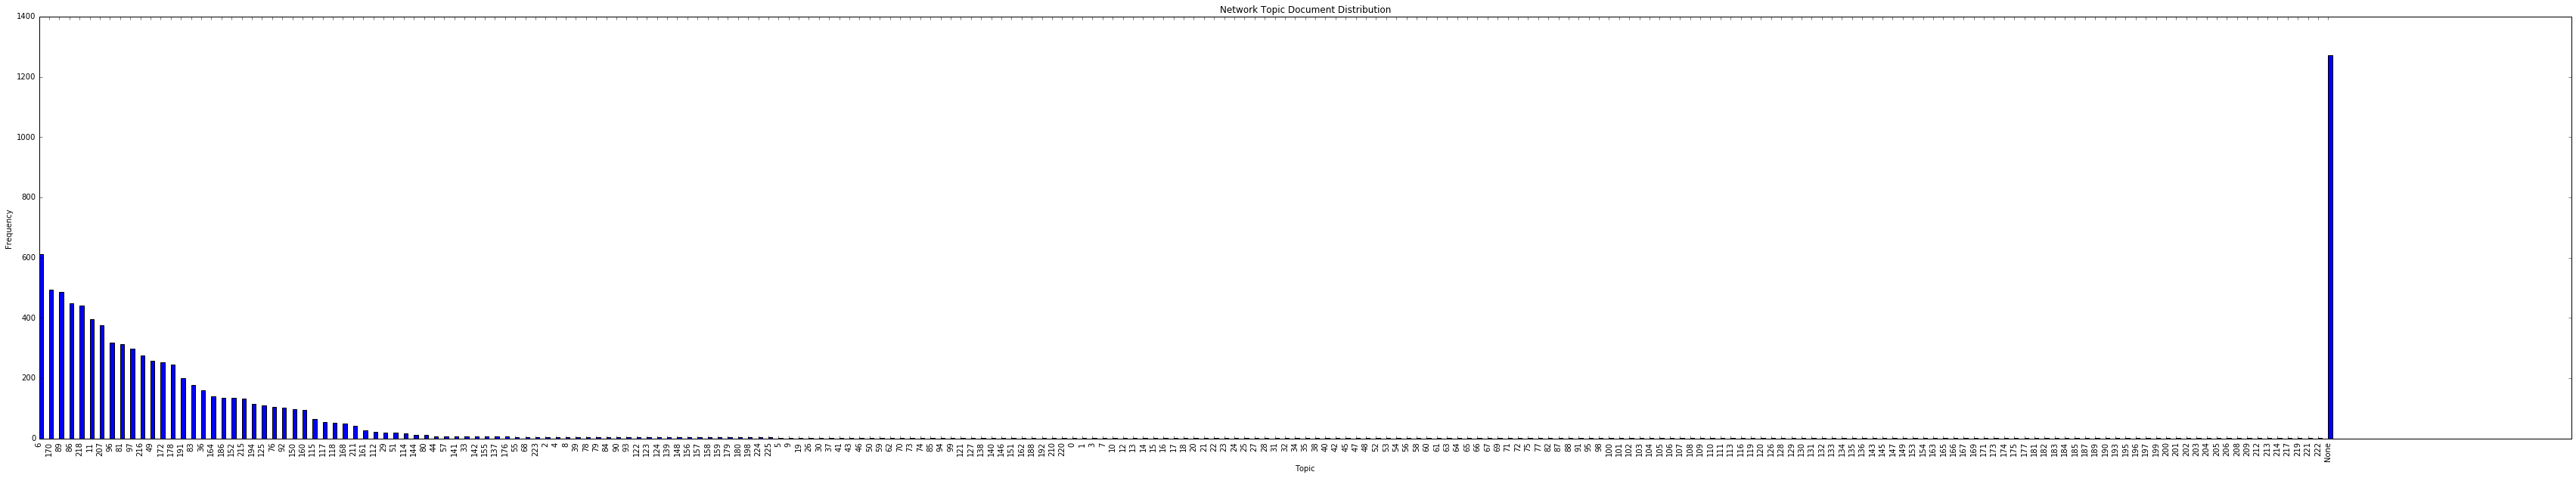

In [214]:
x_data = []
y_data = []
for key, value in sorted(net_topics.items(), key=lambda x: x[1], reverse=True):
    x_data.append(key)
    y_data.append(value)

x_data.append('None')
y_data.append(9086 - 7814)

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(60,10))
plt.bar(ind, y_data)
plt.xticks(ind, x_data, rotation=90)
plt.title("Network Topic Document Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")
plt.show()

# LDA

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=tokenize, stop_words='english')
X = vectorizer.fit_transform(token_values)

print(X.shape)

(9086, 141273)


In [18]:
random.seed(1234)

import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO 

model = lda.LDA(n_topics=226, n_iter=500, random_state=1)
model.fit(X) 

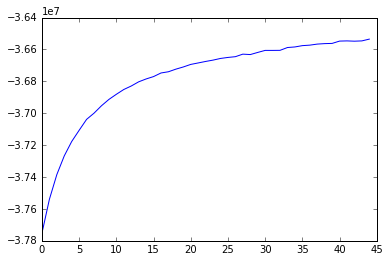

In [125]:
plt.plot(model.loglikelihoods_[5:])

In [20]:
pickle.dump(model, open('tmp/lda.pickle', 'wb'))

## Load Model

In [9]:
model = pickle.load(open('tmp/lda.pickle', 'rb'))

In [10]:
doc_topic = model.doc_topic_
print("type(doc_topic): {}".format(type(doc_topic)))
print("shape: {}".format(doc_topic.shape))

type(doc_topic): <class 'numpy.ndarray'>
shape: (9086, 226)


In [11]:
for n in range(len(doc_topic)):
    topic_most_pr = doc_topic[n].argmax()
    docs[token_keys[n]]['topic_most_pr'] = topic_most_pr

lda_items = sorted(docs.items(), key=lambda x: x[1]['topic_most_pr'])

In [215]:
with open('tmp/lda_docs.txt', 'a') as file:
    for item in lda_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['topic_most_pr'], item[0], item[1]['webTitle']))

In [216]:
with open('tmp/lda_topics.csv', 'a') as file:
    for item in lda_items:
        file.write("{},{}\n".format(item[1]['topic_most_pr'], item[0]))

## Docs per topic

In [ ]:
lda_topics = {}

for item in lda_items:
    topic_no = item[1]['topic_most_pr']
    try:
        lda_topics[topic_no]
    except KeyError:
        lda_topics[topic_no] = 0
        
    lda_topics[topic_no] += 1 
    
len(lda_topics.keys())

In [ ]:
# check missing topic
for i in range(225):
    topics[i]

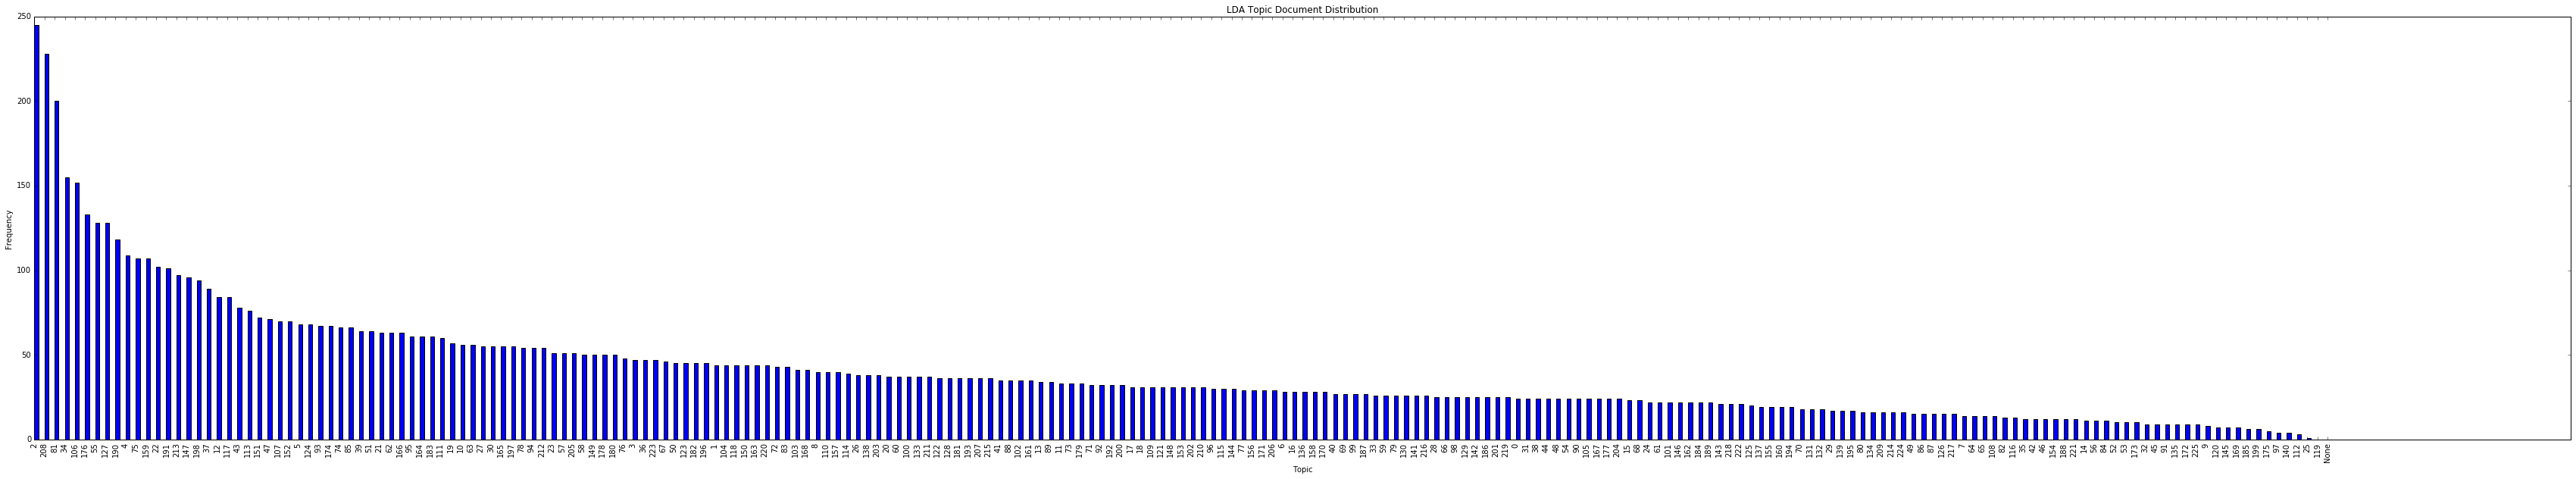

In [149]:
x_data = []
y_data = []
for key, value in sorted(lda_topics.items(), key=lambda x: x[1], reverse=True):
    x_data.append(key)
    y_data.append(value)

x_data.append('119')
y_data.append(0)

x_data.append('None')
y_data.append(0)

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(60,10))
plt.bar(ind, y_data)
plt.xticks(ind, x_data, rotation=90)
plt.title("LDA Topic Document Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")
plt.show()

# Heatmap

In [58]:
topics = {}

for i in range(max(community.membership)):
    for v in community.subgraph(i).vs():
        topic_no = i
        try:
            topics[topic_no]
        except KeyError:
            topics[topic_no] = []

        topics[topic_no].append(v['name'])

net_data = []
for key, value in sorted(topics.items(), key=lambda x: x[0]):
    h = {}
    for v in value:
        h[v] = True
    net_data.append(h)
        
print(len(net_data))
print(net_data[0])

226
{'2016-05-01-3': True, '2016-05-02-13': True}


In [59]:
topics = {}

for item in lda_items:
    topic_no = item[1]['topic_most_pr']
    try:
        topics[topic_no]
    except KeyError:
        topics[topic_no] = []
        
    topics[topic_no].append(item[0])
    
print(len(topics.keys()))
    
lda_data = []
for key, value in sorted(topics.items(), key=lambda x: x[0]):
    h = {}
    for v in value:
        h[v] = True
    lda_data.append(h)

print(len(lda_data))
print(lda_data[0])

225
225
{'2016-05-05-260': True, '2016-05-16-230': True, '2016-05-20-28': True, '2016-05-16-49': True, '2016-05-29-84': True, '2016-05-19-254': True, '2016-05-27-163': True, '2016-05-20-254': True, '2016-05-06-258': True, '2016-05-30-115': True, '2016-05-09-225': True, '2016-05-01-11': True, '2016-05-26-255': True, '2016-05-12-140': True, '2016-05-13-267': True, '2016-05-23-231': True, '2016-05-02-168': True, '2016-05-16-291': True, '2016-05-23-216': True, '2016-05-21-32': True, '2016-05-24-299': True, '2016-05-19-27': True, '2016-05-21-34': True, '2016-05-21-51': True}


In [14]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
vectors  = net_data + lda_data
X = vectorizer.fit_transform(vectors)

print(X.shape)

(451, 9086)


In [15]:
print(len(net_data[0].keys()))
print(len(lda_data[0].keys()))
print(np.count_nonzero(X[:226].toarray()[0]))

2
24
2


In [25]:
net_vectors = X[:226]
lda_vectors = X[226:]

In [26]:
rows = np.dot(net_vectors, np.transpose(lda_vectors))

In [271]:
np.savetxt('tmp/heatmap.csv', rows.toarray(), fmt='%d', delimiter=",")

In [30]:
rows.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

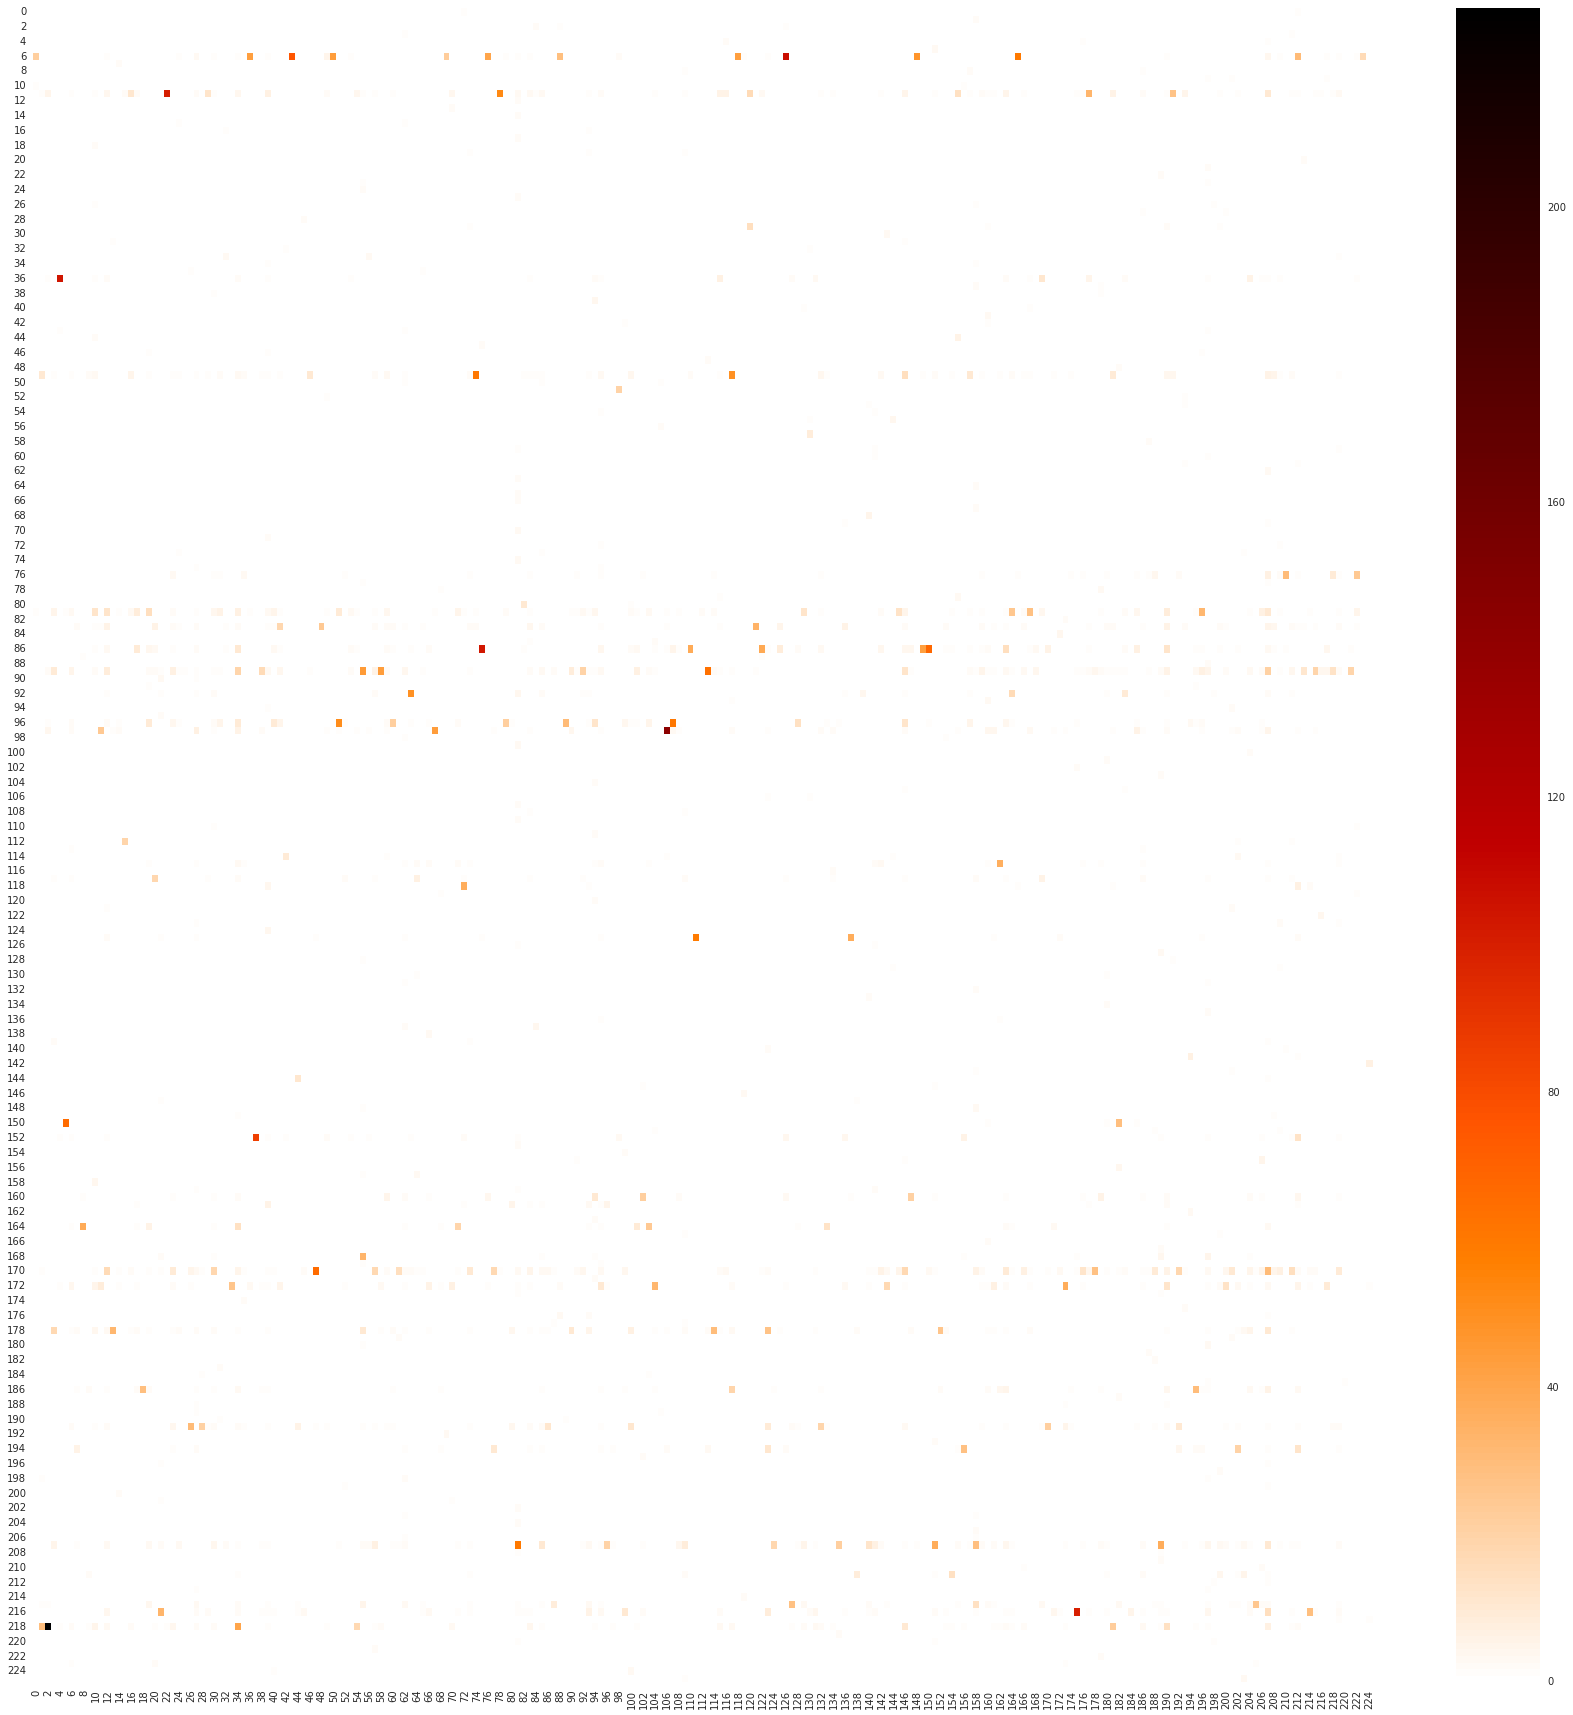

In [48]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(rows.toarray(), xticklabels=2, yticklabels=2, cmap=plt.cm.gist_heat_r)

# Size to topic table + keywords

In [12]:
topics = {}

for i in range(max(community.membership)):
    for v in community.subgraph(i).vs():
        topic_no = i
        try:
            topics[topic_no]
        except KeyError:
            topics[topic_no] = []

        topics[topic_no].append(doc_tokens[v['name']])
        
net_topics = sorted(topics.items(), key=lambda x: len(x[1]), reverse=True)

In [21]:
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
X = vectorizer.fit_transform(token_values)
indices = np.argsort(vectorizer.idf_)[::-1]
features = vectorizer.get_feature_names()
top_n = 10
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

['🤕', 'jordison', 'jorisch', 'jorvik', 'joscelyn', 'josefina', 'josephbarneswinescom', 'josephfashioncom', 'josett', 'josey']


In [25]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [26]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [34]:
print(top_feats_in_doc(X, vectorizer.get_feature_names(), 1, 20))

       feature     tfidf
0     argerich  0.269767
1        piano  0.245852
2   mogilevski  0.179844
3      gautier  0.172105
4      capuçon  0.172105
5       lugano  0.172105
6     debussy’  0.162353
7       arrang  0.158378
8         trio  0.158041
9        suppl  0.153382
10       brahm  0.147303
11    clarinet  0.144114
12          op  0.128151
13        horn  0.106760
14   orchestra  0.103877
15     alexand  0.098610
16      turina  0.089922
17    svizzera  0.089922
18     porteña  0.089922
19       braud  0.089922
